In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
from bs4 import BeautifulSoup
import re
import os
import string
import random

import nltk

from gensim.models import Word2Vec

from nltk import word_tokenize
from nltk.corpus import stopwords

from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score



In [2]:
nltk.download("stopwords")
nltk.download('punkt')

SEED = 42
random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/arbenmiftari/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/arbenmiftari/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Extraction of data from [timeline of events](https://en.wikipedia.org/wiki/Timeline_of_the_21st_century)

Need to download the xml file on this [link](https://en.wikipedia.org/wiki/Special:Export/Timeline_of_the_21st_century)



In [3]:
path = 'datasets/wiki_events.xml'
with open(path, 'r') as f:
    data = f.read()

Bs_data = BeautifulSoup(data, "xml")

In [5]:
plain_txt = Bs_data.text
idx = plain_txt.find('===[[2015]]===')
text = plain_txt[idx:]

In [6]:
text = text.replace('\n\n', '\n')
text = text.replace('[', '')
text = text.replace(']', '')

In [7]:
split_txt = text.split('\n')

In [8]:
copy_txt = split_txt.copy()
new_list=[]
for txt in copy_txt:
    if 'see' in txt:
        continue
    if 'See' in txt:
        break
    if  '2020s' in txt:
        continue
    if '--' in txt:
        continue
    if '===' not in txt:
        new_list.append(txt[2:])
    else:
        new_list.append(txt)

In [9]:
list_tuples = []
for i,element in enumerate(new_list):
    if '===' in element:
        year = element[3:7]
        continue
    list_tuples.append((year, element))

In [10]:
events_df = pd.DataFrame(list_tuples, columns =['Year', 'Event'])

In [11]:
events_df.to_csv('datasets/wiki_events.csv')

# Data exploration to determine controversial videos

In [12]:
#Videos informations and state (num of likes/views) 
data_metadata_path = "data/yt_metadata_helper.feather"
df_metadata = pd.read_feather(data_metadata_path)
df_metadata['dummy']=1
df_metadata.head(5)

,categories,channel_id,dislike_count,display_id,duration,like_count,upload_date,view_count,dummy
0,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,1.0,SBqSc91Hn9g,1159,8.0,2016-09-28,1057.0,1
1,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,1.0,UuugEl86ESY,2681,23.0,2016-09-28,12894.0,1
2,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,779.0,oB4c-yvnbjs,1394,1607.0,2016-09-28,1800602.0,1
3,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,24.0,ZaV-gTCMV8E,5064,227.0,2016-09-28,57640.0,1
4,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,13.0,cGvL7AvMfM0,3554,105.0,2016-09-28,86368.0,1


In [21]:
def check_nan(df):
    check = False
    for col in df.columns:
        if df[col].isnull().values.any():
            print(col)
            check = True
    if not check:
            print('None')
check_nan(df_metadata)

dislike_count
like_count
view_count


In [22]:
df_metadata.fillna(0, inplace=True)
df_metadata.sample(10)

,categories,channel_id,dislike_count,display_id,duration,like_count,upload_date,view_count,dummy
42375026,Music,UCKoafhJ9dkAWaEvlXCiBBwA,353.0,Db50kBPKrEI,235,12177.0,2015-12-18,1763850.0,1
62864264,Howto & Style,UC5Nv7J6ZWm15gix2l8f7ogA,6.0,cpJNDpNCR3A,906,228.0,2017-06-10,5313.0,1
50328078,News & Politics,UCv98nH5lII-twQqyvFVRe8Q,0.0,PyjoI7pkn3E,100,0.0,2017-07-26,91.0,1
11008213,Gaming,UCyeUehuaNsqk5MSEmT7d56A,0.0,kzxTVWZnL6c,365,52.0,2016-01-27,6932.0,1
17270349,Travel & Events,UCeRzkDljKLyOQw2ZcyWJZlA,0.0,rJcwZa7M8nc,53,0.0,2019-03-20,42.0,1
30029524,Gaming,UCV25MAEUSNmGR5CQg5s-Spg,3.0,hkxcXlLCIdo,298,198.0,2013-08-01,13836.0,1
13456087,Entertainment,UChQ9IdwPziDzZOFYerkW8Yg,273.0,WRhbDYhbeps,2245,5198.0,2014-02-12,220692.0,1
53926313,News & Politics,UCCK3OZi788Ok44K97WAhLKQ,21.0,FlzZYBVr3cs,235,334.0,2019-04-26,76934.0,1
16686051,Education,UCy1CuORNZwYAc0ZEF_bOAMA,8.0,mlCCIEDQAXk,237,282.0,2016-01-26,7294.0,1
5661829,Howto & Style,UCyxTPEnNxZEYvUTCziDfAYA,199.0,GujAl30KY70,465,2264.0,2014-10-20,358061.0,1


In [13]:
df_cat_count = df_metadata.copy()
df_cat_count = df_cat_count.groupby("categories", as_index=False).sum()
df_cat_count.drop(labels=[0,8,15], axis=0, inplace=True)

In [14]:
df_cat_count

,categories,dislike_count,duration,like_count,view_count,dummy
1,Autos & Vehicles,6.790556e+07,852657449,9.563003e+08,1.230943e+11,2256967
2,Comedy,2.332550e+08,596953237,6.134163e+09,3.450391e+11,1172503
3,Education,3.853637e+08,3692708661,2.881362e+09,5.023918e+11,3795564
4,Entertainment,1.479342e+09,7666398193,2.014055e+10,2.287748e+12,12276397
5,Film & Animation,3.143058e+08,1505306945,3.737847e+09,5.762808e+11,2359736
6,Gaming,7.142940e+08,19654718199,1.735133e+10,1.042503e+12,13720303
7,Howto & Style,2.924541e+08,2322773279,5.790819e+09,4.206668e+11,3968127
9,Music,8.917641e+08,3913741624,1.927046e+10,2.474987e+12,8305003
10,News & Politics,2.000406e+08,4565935814,1.892883e+09,1.586424e+11,8881022
11,Nonprofits & Activism,1.435273e+07,930119676,2.429490e+08,1.850841e+10,777449


<AxesSubplot:xlabel='categories'>

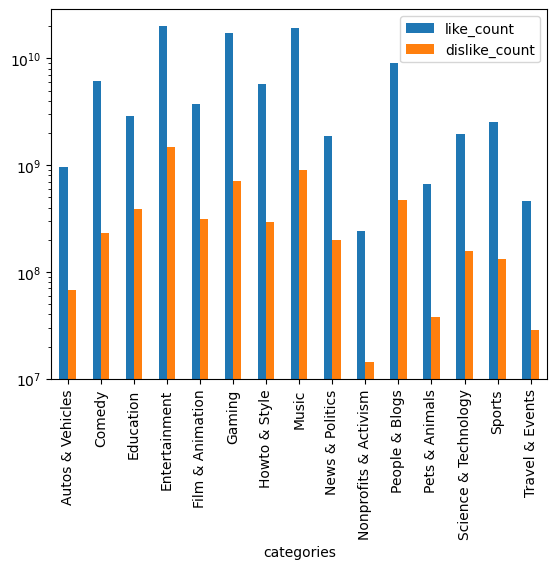

In [15]:
df_cat_count.plot.bar(x='categories', y=['like_count', 'dislike_count'], logy=True)

We observe on this bar plot that the 'News & Politics' is one of the categories with the most amount of dislikes with respect to its total number of likes. It might suggest that this topic deal with subjects that are more controversial.

In [17]:
df_cat_count['ratio']=df_cat_count['dislike_count']/(df_cat_count['like_count']+df_cat_count['dislike_count'])
df_cat_count[['categories', 'ratio']].sort_values(by=['ratio'])
df_cat_count

,categories,dislike_count,duration,like_count,view_count,dummy,ratio
1,Autos & Vehicles,6.790556e+07,852657449,9.563003e+08,1.230943e+11,2256967,0.066301
2,Comedy,2.332550e+08,596953237,6.134163e+09,3.450391e+11,1172503,0.036633
3,Education,3.853637e+08,3692708661,2.881362e+09,5.023918e+11,3795564,0.117966
4,Entertainment,1.479342e+09,7666398193,2.014055e+10,2.287748e+12,12276397,0.068425
5,Film & Animation,3.143058e+08,1505306945,3.737847e+09,5.762808e+11,2359736,0.077565
6,Gaming,7.142940e+08,19654718199,1.735133e+10,1.042503e+12,13720303,0.039539
7,Howto & Style,2.924541e+08,2322773279,5.790819e+09,4.206668e+11,3968127,0.048075
9,Music,8.917641e+08,3913741624,1.927046e+10,2.474987e+12,8305003,0.044229
10,News & Politics,2.000406e+08,4565935814,1.892883e+09,1.586424e+11,8881022,0.095580
11,Nonprofits & Activism,1.435273e+07,930119676,2.429490e+08,1.850841e+10,777449,0.055782


<AxesSubplot:xlabel='categories'>

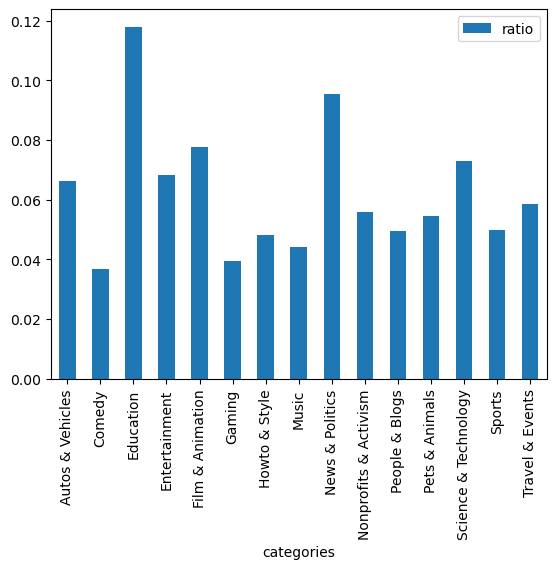

In [18]:
df_cat_count.plot.bar(x='categories', y='ratio')

In [23]:
df = df_metadata.copy()
df['ratio']=df['dislike_count']/(df['like_count']+df['dislike_count'])

In [29]:
df['ratio'].fillna(0, inplace=True)
df['ratio'].isnull().unique()

array([False])

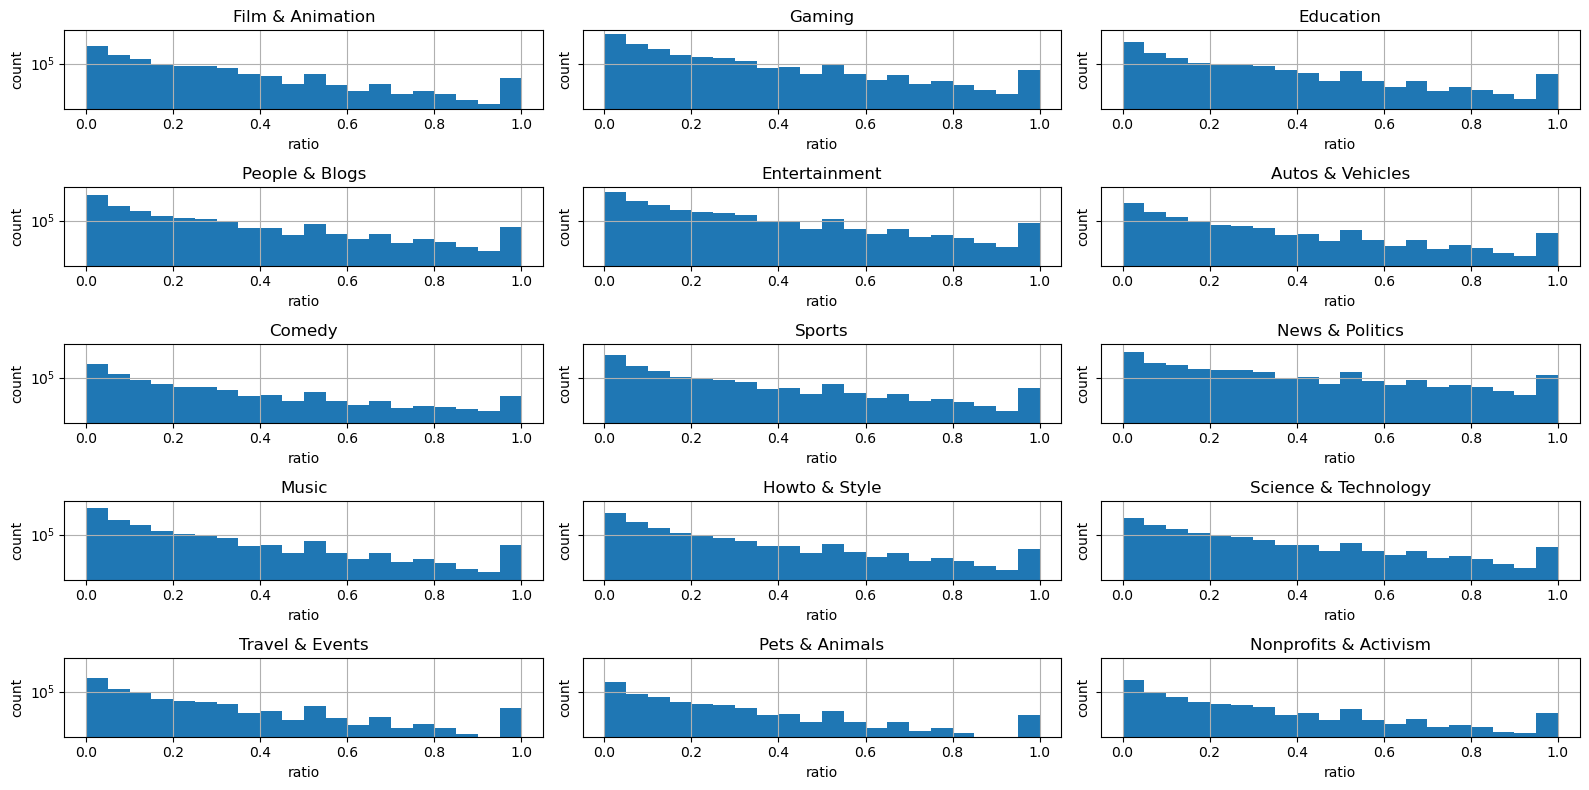

In [45]:
fig, axs = plt.subplots(5,3, figsize=(16,8), sharey=True)

for cat,ax in zip(df['categories'].unique(), axs.ravel()):
    df[df.categories==cat].hist(column='ratio', bins=20 ,ax=ax, log=True)
    ax.set_title(cat)
    ax.set_xlabel('ratio')
    ax.set_ylabel('count')
plt.tight_layout()


We observe that the ratio between dislike and total of likes and dislikes for 'News & Politics' videos is sparser on x-axis compared to other categories. So it means for this topics that the people show more their disagremement towards the content of the video. It can be explained by the fact that these types of videos deal with more controversial subjects. 
Therefore, it would interesing to determine which topics can be considered as more controversial as others. In addition, it would be interesing to also look at the distribution between controversial and non-controversial videos and analyze if these channels upload mostly controversial contents or not.

## Exploration of the content of the video

In [231]:
path = 'data/metadata_chunks/'
csv_files = glob.glob(path+'*.csv.gz')
df0 = pd.read_csv(csv_files[10], usecols=['categories', 'description', 'tags', 'title', 'dislike_count', 'like_count'])
df0.head(5)

,categories,description,dislike_count,like_count,tags,title
0,Sports,Miami Dolphins players react to 43-0 blowout l...,2.0,30.0,"eric rowe,eric rowe dolphins,eric rowe intervi...",Miami Dolphins 2019 Postgame Week 2: Patriots ...
1,Sports,Miami Dolphins quarterback Ryan Fitzpatrick on...,0.0,8.0,"ryan fitzpatrick,ryan fitzpatrick josh rosen,p...",Miami Dolphins QB Ryan Fitzpatrick on 0-2 Star...
2,Sports,Miami Dolphins head coach Brian Flores on 43-0...,8.0,25.0,"brian flores on josh rosen,brian flores on rya...",Dolphins Head Coach Brian Flores on 43-0 loss ...
3,Sports,Mike Trout out for the season per Angles PR. S...,0.0,5.0,"mike trout out for season,mike trout injury 20...",Mike Trout To Have Season Ending Foot Surgery
4,Sports,Miami Dolphins running back Kenyan Drake on Fi...,0.0,3.0,"kenyan drake interview,miami dolphins,brian fl...",Dolphins Running Back Kenyan Drake on Free Age...


In [232]:
df_raw = df0.drop_duplicates(subset=['title'])
df_raw["video_info"] = df_raw['title'].astype(str) +": "+ df_raw["description"]
df_raw = df_raw.drop(['title'],  axis=1)
df_raw = df_raw.drop(['description'], axis=1)
df_raw = df_raw[df_raw.categories=='News & Politics']
df_raw = df_raw[df_raw.dislike_count+df_raw.like_count > 50]
df_raw['ratio']=df_raw['dislike_count']/(df_raw['like_count']+df_raw['dislike_count'])
df_raw['ratio'].fillna(0, inplace=True)
df_raw['ratio'].isnull().unique()
df_raw = df_raw.drop(['dislike_count', 'like_count', 'categories'],  axis=1)
df_raw.sample(5)

/var/folders/yb/s0f6sw2927z0fg31yb0l2zyc0000gn/T/ipykernel_84511/3832634835.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw["video_info"] = df_raw['title'].astype(str) +": "+ df_raw["description"]


,tags,video_info,ratio
71945,"bay area news,kron4,KRON 4 News,People Behavin...",Many Drivers Behave Badly in Red Transit Lanes...,0.044444
64331,"stranger things season 2,stranger,things,seaso...",STRANGER THINGS Season 2 | New Cast Details + ...,0.011650
18552,"screen hoopla,screen hoopla news,trump news,tr...",Chris Wallace Crushes Dems After They Blocked ...,0.000000
72963,NaN,NaN,0.038462
46616,NaN,"Leftist Reading: Capital - Vol 1, Chapter 2: M...",0.059289


In [233]:
# keep only videos whose ratio is higher than the median
quantile = df_raw['ratio'].quantile(0.25)
print(quantile)
df_raw = df_raw[df_raw.ratio > quantile]
df_raw.sample(5)

0.014124293785310734


,tags,video_info,ratio
18523,"screen hoopla53.6,screen hoopla news,trump new...",NO ONE CAN HELP Hillary & MORE THIS TIME!! Hou...,0.014430
64350,"stranger things,stranger,things,interview,mons...",STRANGER THINGS: MAKING THE MONSTER featuring ...,0.017241
69355,"bay area news,kron4",Santana Bandmate Marcus Malone Interview Raw: ...,0.031424
18989,"screen hoopla,screen hoopla news,trump news,tr...",WHAT'S BEHIND THE SUDDEN SURGE OF SEN. WARRENS...,0.021739
67239,"bay area news,kron4",Tenants Angry After Landlord Shuts Off Their W...,0.130000


In [234]:
def clean_text(text, tokenizer, stopwords):
    text = str(text).lower()  # Lowercase words
    text = re.sub(r"\[(.*?)\]", "", text)  # Remove [+XYZ chars] in content
    text = re.sub(r"\s+", " ", text)  # Remove multiple spaces in content
    text = re.sub(r"\w+…|…", "", text)  # Remove ellipsis (and last word)
    text = re.sub(r"(?<=\w)-(?=\w)", " ", text)  # Replace dash between words
    text = re.sub(
        f"[{re.escape(string.punctuation)}]", "", text
    )  # Remove punctuation

    tokens = tokenizer(text)  # Get tokens from text
    tokens = [t for t in tokens if not t in stopwords]  # Remove stopwords
    tokens = ["" if t.isdigit() else t for t in tokens]  # Remove digits
    tokens = [t for t in tokens if len(t) > 1]  # Remove short tokens
    return tokens

In [235]:
# preprocessing our dataframe to be clustered
custom_stopwords = set(stopwords.words("english"))

df = df_raw.copy()

# we need to tokenize our texts.
df["text"] = df_raw['video_info']
df["tokens"] = df["text"].map(lambda x: clean_text(x, word_tokenize, custom_stopwords))

# Remove duplicated after preprocessing
_, idx = np.unique(df["tokens"], return_index=True)
df = df.iloc[idx, :]

# Remove empty values and keep relevant columns
df = df.loc[df.tokens.map(lambda x: len(x) > 0), ["text", "tokens"]]

docs = df["text"].values
tokenized_docs = df["tokens"].values

print(f"Original dataframe: {df_raw.shape}")
print(f"Pre-processed dataframe: {df.shape}")

Original dataframe: (891, 3)
Pre-processed dataframe: (885, 2)


In [236]:
# transform our sentences into numerical vectors
model = Word2Vec(sentences=tokenized_docs, vector_size=100, workers=1, seed=SEED)

In [237]:
# Generate vectors for list of documents using a Word Embedding

def vectorize(list_of_docs, model):
    features = []

    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model.wv:
                try:
                    vectors.append(model.wv[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features
    
vectorized_docs = vectorize(tokenized_docs, model=model)
len(vectorized_docs), len(vectorized_docs[0])

(885, 100)

In [238]:
# Generate clusters and print Silhouette metrics using MBKmeans
def mbkmeans_clusters(X, k, mb, print_silhouette_values):
    """
    Params:
        X: Matrix of features.
        k: Number of clusters.
        mb: Size of mini-batches.
        print_silhouette_values: Print silhouette values per cluster.
    """
    km = MiniBatchKMeans(n_clusters=k, batch_size=mb).fit(X)
    print(f"For n_clusters = {k}")
    print(f"Silhouette coefficient: {silhouette_score(X, km.labels_):0.2f}")

    if print_silhouette_values:
        sample_silhouette_values = silhouette_samples(X, km.labels_)
        print(f"Silhouette values:")
        silhouette_values = []
        for i in range(k):
            cluster_silhouette_values = sample_silhouette_values[km.labels_ == i]
            silhouette_values.append(
                (
                    i,
                    cluster_silhouette_values.shape[0],
                    cluster_silhouette_values.mean(),
                    cluster_silhouette_values.min(),
                    cluster_silhouette_values.max(),
                )
            )
        silhouette_values = sorted(
            silhouette_values, key=lambda tup: tup[2], reverse=True
        )
        for s in silhouette_values:
            print(
                f"    Cluster {s[0]}: Size:{s[1]} | Avg:{s[2]:.2f} | Min:{s[3]:.2f} | Max: {s[4]:.2f}"
            )
    return km, km.labels_

In [239]:
clustering, cluster_labels = mbkmeans_clusters(
	X=vectorized_docs,
    k=200,
    mb=500,
    print_silhouette_values=True,
)
df_clusters = pd.DataFrame({
    "text": docs,
    "tokens": [" ".join(text) for text in tokenized_docs],
    "cluster": cluster_labels
})

For n_clusters = 200
Silhouette coefficient: 0.24
Silhouette values:
    Cluster 194: Size:3 | Avg:1.00 | Min:1.00 | Max: 1.00
    Cluster 185: Size:17 | Avg:0.95 | Min:0.66 | Max: 0.97
    Cluster 11: Size:8 | Avg:0.87 | Min:0.79 | Max: 0.90
    Cluster 46: Size:2 | Avg:0.79 | Min:0.78 | Max: 0.79
    Cluster 107: Size:8 | Avg:0.78 | Min:0.70 | Max: 0.81
    Cluster 167: Size:3 | Avg:0.75 | Min:0.73 | Max: 0.78
    Cluster 15: Size:11 | Avg:0.74 | Min:0.49 | Max: 0.82
    Cluster 70: Size:7 | Avg:0.73 | Min:0.63 | Max: 0.77
    Cluster 145: Size:4 | Avg:0.66 | Min:0.64 | Max: 0.68
    Cluster 5: Size:2 | Avg:0.64 | Min:0.64 | Max: 0.65
    Cluster 7: Size:25 | Avg:0.64 | Min:0.40 | Max: 0.74
    Cluster 32: Size:4 | Avg:0.62 | Min:0.00 | Max: 0.83
    Cluster 69: Size:3 | Avg:0.58 | Min:0.56 | Max: 0.60
    Cluster 94: Size:2 | Avg:0.58 | Min:0.57 | Max: 0.59
    Cluster 57: Size:6 | Avg:0.57 | Min:0.39 | Max: 0.69
    Cluster 87: Size:3 | Avg:0.54 | Min:0.40 | Max: 0.63
    Cluster 5

In [240]:
print("Most representative terms per cluster (based on centroids):")
for i in range(200):
    tokens_per_cluster = ""
    most_representative = model.wv.most_similar(positive=[clustering.cluster_centers_[i]], topn=5)
    for t in most_representative:
        tokens_per_cluster += f"{t[0]} "
    print(f"Cluster {i}: {tokens_per_cluster}")

Most representative terms per cluster (based on centroids):
Cluster 0: story full httpnewskron4com badly behaving 
Cluster 1: plus oath terry cut spin 
Cluster 2: word ocasio peter bring vision 
Cluster 3: social media ►► connect httpwwwpatreoncomfoundflix 
Cluster 4: story httpnewskron4com full behaving badly 
Cluster 5: view story httpnewskron4com full bike 
Cluster 6: oath terry spin cut reality 
Cluster 7: newstrump httpsyoutubeo1mvuplnpqs newsdonald hooplascreen news 
Cluster 8: drivers pbb behave looks rides 
Cluster 9: kron 4s roberts behave drivers 
Cluster 10: im clear black rather lose 
Cluster 11: httpsyoutubey8rt3ouyj8 httpsyoutubefmykui1tjwm seminar p0i0uczq httpsyoutubeohq7lrsp 
Cluster 12: story httpnewskron4com full behaving bike 
Cluster 13: ago earn peoples monetary gain 
Cluster 14: carpool san street looks parking 
Cluster 15: httpsyoutubeo1mvuplnpqs newstrump newsdonald plus loose 
Cluster 16: address page pakistan thoughts august 
Cluster 17: ever spot wise housin